## Shor's Algorithm
Within this notebook we implement Shor's algorithm in three ways.

1. <b>Helper Functions</b>: Initially we establish a set of helper functions for our Shor's implementations. 
2. <b>Classical Shor's</b>: Then we use these helper functions to write a full Shor's implementation, which returns the full prime factorization of any integer number that satifies the requirements. 
3. <b>Classical Optimized</b>: We then benchmark our Shor's classical implementation against an optimized sympy factorization library. 
4. <b>Quantum Shor's</b>: Borrowing from previously established work, we test a small input implementation of a quantum implentation of shor's algorithm. 
5. <b>Potential Applications</b>: To illuminate usefulness, we set up and apply our factorization method to a simple potential application.
6. <b>Results/Evaluation</b>: Finally, we evaluate and compare our various implementations via a timing function. 

 Initially we establish a set of helper functions for our Shor's implmentation. Then we write the full factorization algorithm, which we loop for larger numbers to find the prime factorization of any number that satisfies the conditions.  

In [40]:
# import libraries
import numpy as np
import math
import sympy
import timeit
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import sys

### Helper Functions

First we'll define a series of helper functions to our main factorization function. 

Each one will be as self contained as possible.

Implementation of this method: https://kaustubhrakhade.medium.com/shors-factoring-algorithm-94a0796a13b1

In [41]:
# define for later exception handling
class CustomException(Exception):
    pass

In [42]:
def check_N_conditions(N):
    # make sure not even
    if N % 2 == 0:
        # print(N, "is even, faield test 1")
        return False
    
    if sympy.isprime(N):
        # print(N, "is prime, failed test 2")
        return False
    
    # O(sqrt(n)) loop to check every number to N
    for i in range(2, int(math.sqrt(N))+1):
        
        # make sure not of form n**x
        x = 2
        while i**x <= N: 
            if i**x == N:
                # print(N, " is of form N**x, faield test 3")
                return False
            x += 1

    return True

"""
# Test cases with expected results
test_cases = [9, 27, 15, 20, 37, 64, 81, 121, 7, 49, 16, 18, 23, 25, 11]
expected_results = [False, False, True, False, True, False, False, False, True, False, False, False, True, False, True]

# Running the test cases
for i, test in enumerate(test_cases):
    result = check_N_conditions(test)
    print(f"Test case {i+1}: N={test}, Expected={expected_results[i]}, Result={result}, {'Passed' if result == expected_results[i] else 'Failed'}")
"""

'\n# Test cases with expected results\ntest_cases = [9, 27, 15, 20, 37, 64, 81, 121, 7, 49, 16, 18, 23, 25, 11]\nexpected_results = [False, False, True, False, True, False, False, False, True, False, False, False, True, False, True]\n\n# Running the test cases\nfor i, test in enumerate(test_cases):\n    result = check_N_conditions(test)\n    print(f"Test case {i+1}: N={test}, Expected={expected_results[i]}, Result={result}, {\'Passed\' if result == expected_results[i] else \'Failed\'}")\n'

In [43]:
# define helper func to get random candidate k
def choose_k(N, tried_k=[]):
    possible_k = np.arange(1, N) # initialize possible k values
    for k in tried_k:
        possible_k = possible_k[possible_k != k] # remove already tried k values
    
    return np.random.choice(possible_k) # return random k value

In [44]:
# make sure k doesn't share factors with N
def check_gcd(N, k):
    return np.gcd(N, k) == 1

This next function is the classical implementation of what could be a quantum implementation. Without the quantum implementation, We believe Shor's method is slower than alternative factoring algorithms in the classical paradigm.

In [45]:
# main step 4 that should become quantized....
def get_order_and_transformation(N, k):
    q = 1 # q is arbitrary starting value
    remainders = []

    # refer to step 4 in the paper for more information
    # iterate through semi-random q and updates
    while (q*k) % N != 1:
        q = (q*k) % N
        remainders.append(q) 

    q = (q*k) % N
    remainders.append(q)
    
    return len(remainders), remainders

In [46]:
# get p value from transformation history
def get_p(r, tranformation_remainders):
    return tranformation_remainders[int(r/2 - 1)]

This is for later, but will help us generate random numbers that we might want to factorize.

In [47]:
def generate_random_non_prime_odd(magnitude):
    lower = 10 ** magnitude
    upper = (10 ** (magnitude + 1)) - 1

    while True:
        num = np.random.randint(lower, upper)
        
        # Ensure the number is odd
        if num % 2 == 0:
            num += 1
        
        # Ensure the number is not prime
        if not sympy.isprime(num):
            return num

### Factorization!
Here we put all helper functions together into one main function that returns two factors of the given number. 

In [48]:
def factorize(N=781):

    # Step 1: define N that satisfies conditions
    not_done = True

    if not check_N_conditions(N):
        # print("N does not satisfy conditions")
        raise CustomException("N does not satisfy conditions.")

    while not_done:
        r = 1

        # Step 2: Choose a random k
        k = choose_k(N)

        # Step 3: Check if gcd(N, k) = 1
        if check_gcd(N, k):
            pass
        else: 
            # print("factors of ", N, "are", np.gcd(k, N), "and", int(N/np.gcd(k, N)), "\n")
            # print("random value k = ", k, ", order r = ", 0, ", middle remainder p = n/a")
            return np.gcd(k, N), int(N/np.gcd(k, N))

        # Step 4: Find the order of k mod N
        r, tranformation_remainders = get_order_and_transformation(N, k)

        # Step 5: If the order is odd, go back to step 2
        if r % 2 != 0:
            not_done = True
            continue

        # Step 6: Define p
        p = get_p(r, tranformation_remainders)
        if p + 1 == N: 
            not_done = True
            continue

        not_done = False

    # Step 7: find and print factors
    print("factors of ", N, "are", np.gcd(p+1, N), "and", np.gcd(p-1, N), "\n")
    print("random value k = ", k, ", order r = ", r, ", middle remainder p = ", p)

    return np.gcd(p+1, N), np.gcd(p-1, N)

In [49]:
def shor_classical_factorization(n):

    # define factorize function
    def recursive_factorize(n, factors):

        # base case where last factor is 1
        if n == 1:
            return factors
        
        # base case where remaining factors are prime
        if sympy.isprime(n):
            factors[n] = factors.get(n, 0) + 1
            return factors
        
        # otherwise try to factorize
        try:
            factor1, factor2 = factorize(n)
        except CustomException: # exception handling
            raise CustomException("N does not satisfy conditions.")
        
        # recursively factorize the factors
        if sympy.isprime(factor1):
            factors[factor1] = factors.get(factor1, 0) + 1
        else:
            recursive_factorize(factor1, factors)
        if sympy.isprime(factor2):
            factors[factor2] = factors.get(factor2, 0) + 1
        else:
            recursive_factorize(factor2, factors)

        return factors

    # initialize and call factorize
    factors = {}
    return recursive_factorize(n, factors)

In [50]:
# quick test to see if number we want to factorize satisfied conditions or not
try:
    shor_classical_factorization(50)
except CustomException as e:
    print(e)

N does not satisfy conditions.


### Classical Optimized Version

We'll use sympy's library for a strong example of fully optimized classical factorization techniques. 

In [51]:
def classical_factorization(n):
    return sympy.factorint(n)

### Quantum Implementation of Shor's Algorithm

Method 1: We borrow this code from a previous implementation of the paper: <a href="https://arxiv.org/pdf/quant-ph/0205095">Circuit for Shor’s algorithm using 2n+3 qubits</a>. The implementation can be found <a href="https://github.com/jmpr1991/Shor_algorithm">here</a>. While this implementation is robust to undefined input sizes, I've found it to be a sub-optimal implementation, hence taking 10+ minutes to converge. 

In [52]:
from failed_attempts.quantum_shors.jmpr_qc_algo import myfunctions

# circuit, period, factors = myfunctions.shor_algo()

Method 2: Given the state of advancement of quantum computing today, practical factorization in reasonable amounts of time are generally limited to really small integer values, the most common example being 15. I implement one such solution that is borrowed and reimplemented from <a href="https://github.com/mett29/Shor-s-Algorithm?tab=readme-ov-file">here</a>. 

The full implementation can be found in the quantum_shor.ipynb notebook, however I include the basic results here as hardcoded variables.

In [53]:
quantum_shors_n = 15
quantum_shors_time = 0.2674624170176685 # seconds

### General Applications

Let's consider we're a group of true physicists, who are practicing imagining multiple dimensions. To practice this we're going to consider building an animal stable that is exactly some square meterage (ex. 385 sq m), but we don't know the exact dimensions of stable! We're going to find a way to visualize the dimensions of this stable. 

Fundamentally this is a factoring challenge - given some number (like 385), we'd like to factor it into the most fundamental factors so we can maximize the number of dimensions and reduce the measure of length of each dimension.

In [54]:
# visualize if 2 factors
def vis_2d(factors):
    width, height = factors
    fig, ax = plt.subplots()
    
    # Calculate the lower-left corner position
    lower_left_x = -width / 2
    lower_left_y = -height / 2
    
    # create and plot rectangle
    rectangle = plt.Rectangle((lower_left_x, lower_left_y), width, height, edgecolor='black', facecolor='green', alpha=0.5)
    ax.add_patch(rectangle)
    
    # set scaling of display
    ax.set_xlim(lower_left_x - 1, lower_left_x + width + 1)
    ax.set_ylim(lower_left_y - 1, lower_left_y + height + 1)
    
    # plot
    plt.xlabel('Width')
    plt.ylabel('Height')
    plt.title('2D Rectangle')
    plt.grid(True)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

In [55]:
# visualize if 3 factors
def vis_3d(factors):
    width, depth, height = factors
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # create vertices for cuboid centered at the origin
    vertices = [[-width / 2, -depth / 2, -height / 2], [width / 2, -depth / 2, -height / 2],
                [width / 2, depth / 2, -height / 2], [-width / 2, depth / 2, -height / 2],
                [-width / 2, -depth / 2, height / 2], [width / 2, -depth / 2, height / 2],
                [width / 2, depth / 2, height / 2], [-width / 2, depth / 2, height / 2]]
    
    # create sides using the vertices
    sides = [[vertices[j] for j in [0, 1, 2, 3]],
             [vertices[j] for j in [4, 5, 6, 7]], 
             [vertices[j] for j in [0, 3, 7, 4]], 
             [vertices[j] for j in [1, 2, 6, 5]], 
             [vertices[j] for j in [0, 1, 5, 4]], 
             [vertices[j] for j in [2, 3, 7, 6]]]
    
    # plot sides
    ax.add_collection3d(Poly3DCollection(sides, facecolors='green', linewidths=1, edgecolors='black', alpha=.25))
    
    # set scaling of display
    ax.set_xlim(-width / 2 - 1, width / 2 + 1)
    ax.set_ylim(-depth / 2 - 1, depth / 2 + 1)
    ax.set_zlim(-height / 2 - 1, height / 2 + 1)
    
    # plot
    ax.set_xlabel('Width')
    ax.set_ylabel('Depth')
    ax.set_zlabel('Height')
    plt.title('Visualizing 3D Animal Stable of exactly 385 sq m')
    plt.show()

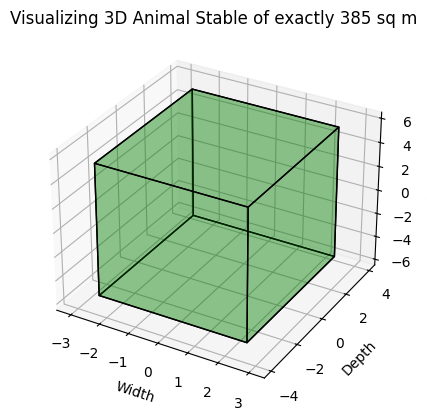

In [56]:
N = 385 # define factorization number

try :
    factors = list(classical_factorization(N).keys()) # get factors
    
    if len(factors) == 2:
        vis_2d(factors)
    elif len(factors) == 3:
        vis_3d(factors)

except CustomException as e:
    print(e)

Great! We've discovered that the best multi-dimensional animal stable is of width = 5, depth = 7, and height = 11. We can imagine that as we scale this problem to larger numbers of magnitude 10^6, our prime factorization might be of 4 or more dimensions, hence this simple visualization and "optimization" would not be so trivial. 

Recognizing this is a contrived application, we'll also recognize factorization and prime factorization has many more well-documented applications in cryptography, specifically to break the foremost encryption protocol RSA. To learn more about that application, I suggest the following minutephysics video: <a href="https://www.youtube.com/watch?v=lvTqbM5Dq4Q&ab_channel=minutephysics" >https://www.youtube.com/watch?v=lvTqbM5Dq4Q&ab_channel=minutephysics</a>.

### Testing and Plotting

Great! Now we're ready to analyze our results. Here we plot input size against time our algorithms took to understand the scaling of each algorithm. 

In [57]:
nums_to_factor, shor_times, classical_times = [], [], []

for num in [15, 51, 329, 1037, 23083, 492371, 2323781, 97451835, 391739481]: # hard-code list of nums to factor
    nums_to_factor.append(num)

    # time and store shor factorization
    try:
        shor_time = timeit.timeit(f"factorize({num})", globals=globals(), number=1) 
        shor_times.append(shor_time)
    except CustomException as e:
        shor_times.append(None)


    # time and store classical factorization
    try:
        classical_time = timeit.timeit(f"shor_classical_factorization({num})", globals=globals(), number=1)
        classical_times.append(classical_time)
    except CustomException as e:
        classical_times.append(None)

factors of  15 are 5 and 3 

random value k =  2 , order r =  4 , middle remainder p =  4
factors of  51 are 17 and 3 

random value k =  47 , order r =  4 , middle remainder p =  16
factors of  329 are 47 and 7 

random value k =  312 , order r =  138 , middle remainder p =  281
factors of  329 are 7 and 47 

random value k =  150 , order r =  138 , middle remainder p =  48
factors of  1037 are 17 and 61 

random value k =  894 , order r =  48 , middle remainder p =  611
factors of  1037 are 17 and 61 

random value k =  727 , order r =  60 , middle remainder p =  611
factors of  23083 are 41 and 563 

random value k =  13561 , order r =  2810 , middle remainder p =  16891
factors of  23083 are 41 and 563 

random value k =  5541 , order r =  11240 , middle remainder p =  16891
factors of  492371 are 17 and 28963 

random value k =  455172 , order r =  26320 , middle remainder p =  405483
factors of  492371 are 44761 and 11 

random value k =  247998 , order r =  13160 , middle remain

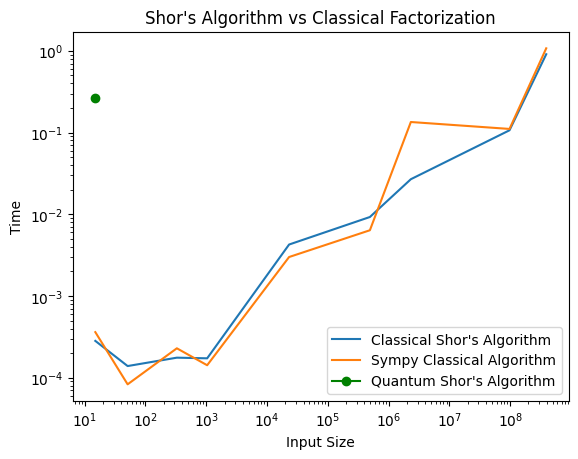

In [58]:
# plot the times versus input size for both algorithms
plt.loglog(nums_to_factor, shor_times,
    label="Classical Shor's Algorithm")
plt.loglog(nums_to_factor, classical_times, 
    label="Sympy Classical Algorithm")
plt.loglog(quantum_shors_n, quantum_shors_time, 
    label="Quantum Shor's Algorithm",
    marker='o', color='green')
plt.xlabel("Input Size")
plt.ylabel("Time")
plt.title("Shor's Algorithm vs Classical Factorization")
plt.legend()
plt.show()